In [1]:
from torchsummary import summary
import numpy as np
import os
import time
import math
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device is : ", device)


current device is :  cuda


In [2]:
'''
Liver Datasets Loader
'''


class LiverDataset(Dataset):
    def __init__(self, state):
        self.state = state
        self.train_root = r"../dataset/liver/train"
        self.val_root = r"../dataset/liver/val"

        # 若assert为异常值，则报错
        assert self.state == 'train' or self.state == 'val'
        if self.state == 'train':
            root = self.train_root
        if self.state == 'val':
            root = self.val_root

        pics = []
        masks = []
        n = len(os.listdir(root)) // 2  # 因为数据集中一套训练数据包含有训练图和mask图，所以要除2
        for i in range(n):
            pics.append(os.path.join(root, "%03d.png" % i))  # liver is %03d
            masks.append(os.path.join(root, "%03d_mask.png" % i))
        self.pics, self.masks = pics, masks

        self.transform = T.Compose(
            [T.Grayscale(), T.Resize((512, 512), interpolation=Image.NEAREST), T.ToTensor()])

    def __getitem__(self, index):
        origin_x = Image.open(self.pics[index])
        origin_y = Image.open(self.masks[index])
        return self.transform(origin_x), self.transform(origin_y)

    def __len__(self):
        return len(self.pics)


liver_dataset = LiverDataset(state='train')

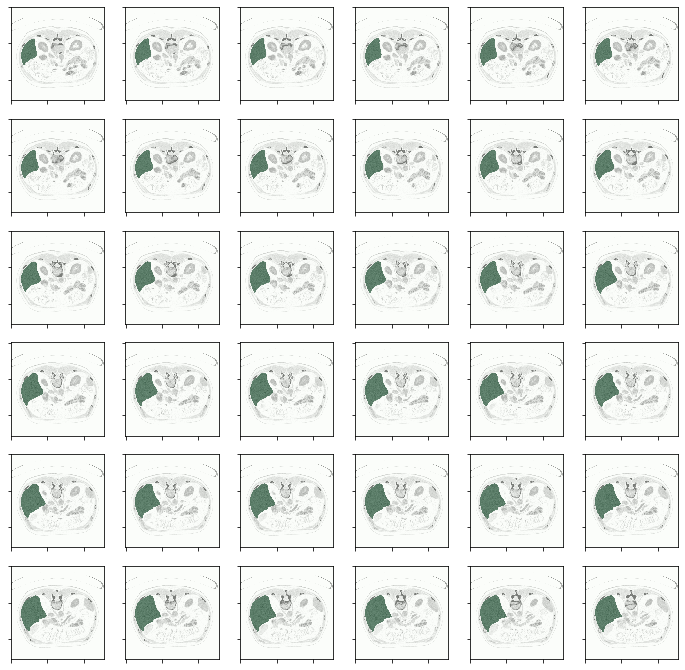

In [3]:
'''
overwatch the dataset
'''
max_images = 36
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(range(max_images)):
    image, mask = liver_dataset[idx]
    
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")

    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.show()

In [4]:
'''
Essential part of UNet model
'''


class conv_block(nn.Module):
    '''
    activation: 默认使用激活函数
    in_channels: 输入的feature map的通道数
    out_channels: 输出的out_channels的通道数
    kernel_size: 卷积核的大小
    stride: 步长
    padding: 补0（zero-padding）的数量
    '''

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, activation=True):
        '''
        super()函数：用来解决类的继承问题
        此处：super会将conv_block的对象转化成nn.Module的对象，从而调用nn.Module的__init__()初始化函数
        '''
        super(conv_block, self).__init__()  # run : nn.Module.__init__()
        self.activation = activation
        # // : 代表整除法
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride=stride, padding=kernel_size//2)
        self.norm = nn.BatchNorm2d(out_channels)

    # 前向传播函数
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        if self.activation:
            return F.relu(x)
        else:
            return x


class up_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            # 升采样，使用‘bilinear’模式（upsample和convTransposed的区别是upsample不需要训练参数）
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


In [5]:


class Attention_Block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_Block, self).__init__()
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,
                      stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,
                      stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.sigma_1 = nn.ReLU(inplace=True)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1)
        )
        self.sigma_2 = nn.Sigmoid()
        self.test_print = True

    def forward(self, g, x):

        g1 = self.W_g(g)
        x1 = self.W_x(x)

        sigma1 = self.sigma_1(g1+x1)
        psi = self.psi(sigma1)

        sigma2 = self.sigma_2(psi)

        res = x*sigma2
        if self.test_print is True:
            print(sigma2.size(), res.size())
        self.test_print = False
        return res



In [6]:
'''
UNet Model 
'''


class AttU_Net(nn.Module):
    def __init__(self, img_channels=1, num_classes=1):
        super(AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_channels=img_channels, out_channels=64)
        self.Conv2 = conv_block(in_channels=64, out_channels=128)
        self.Conv3 = conv_block(in_channels=128, out_channels=256)
        self.Conv4 = conv_block(in_channels=256, out_channels=512)
        self.Conv5 = conv_block(in_channels=512, out_channels=1024)

        self.Up5 = up_conv(in_channels=1024, out_channels=512)
        self.Att5 = Attention_Block(F_g=512, F_l=512, F_int=256)
        self.Up_conv5 = conv_block(in_channels=1024, out_channels=512)

        self.Up4 = up_conv(in_channels=512, out_channels=256)
        self.Att4 = Attention_Block(F_g=256, F_l=256, F_int=128)
        self.Up_conv4 = conv_block(in_channels=512, out_channels=256)

        self.Up3 = up_conv(in_channels=256, out_channels=128)
        self.Att3 = Attention_Block(F_g=128, F_l=128, F_int=64)
        self.Up_conv3 = conv_block(in_channels=256, out_channels=128)

        self.Up2 = up_conv(in_channels=128, out_channels=64)
        self.Att2 = Attention_Block(F_g=64, F_l=64, F_int=32)
        self.Up_conv2 = conv_block(in_channels=128, out_channels=64)

        self.Conv_1x1 = nn.Conv2d(
            64, num_classes, kernel_size=1, stride=1, padding=0)

        self.test_print = True

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        if self.test_print is True:
            print("d5", d5.size(), "x4", x4.size())
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        self.test_print = False
        return d1


model = AttU_Net().to(device)
# summary(model, (1, 128, 128)) # 无法进行summary


In [7]:

# IOU指标
def get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs < 0., torch.zeros_like(
        outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1, 2))
    union = (A | B).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou

# DICE指标
def dice_coef(outputs, labels):#output为预测结果 target为真实结果
    smooth = 1e-6 #防止0除
    if torch.is_tensor(outputs):
        outputs = torch.sigmoid(outputs).data.cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.data.cpu().numpy()

    intersection = (outputs * labels).sum()
    dice = (2. * intersection + smooth) / (outputs.sum() + labels.sum() + smooth)

    return dice

# precision 和 recall 指标
def precision_and_recall(label_gt, label_pred, n_class):
    from sklearn.metrics import precision_score, recall_score
    assert len(label_gt) == len(label_pred)
    precision = np.zeros(n_class, dtype=np.float32)
    recall = np.zeros(n_class, dtype=np.float32)
    img_A = np.array(label_gt, dtype=np.float32).flatten()
    img_B = np.array(label_pred, dtype=np.float32).flatten()
    precision[:] = precision_score(img_A, img_B, average=None, labels=range(n_class))
    recall[:] = recall_score(img_A, img_B, average=None, labels=range(n_class))

    return precision, recall

# accuracy指标
def get_accuracy(outputs,labels,threshold=0.5):
    outputs = outputs > threshold
    labels = labels == torch.max(labels)
    corr = torch.sum(outputs==labels)
    tensor_size = outputs.size(0)*outputs.size(1)*outputs.size(2)*outputs.size(3)
    acc = float(corr)/float(tensor_size)
 
    return acc

# sensitivity指标
# Sensitivity == Recall
def get_sensitivity(outputs,labels,threshold=0.5):
    outputs = outputs > threshold
    labels = labels == torch.max(labels)

    # TP : True Positive
    # FN : False Negative
    TP = ((outputs==1).byte() + (labels==1).byte()) == 2
    FN = ((outputs==0).byte() + (labels==1).byte()) == 2
    SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-6)     
    return SE

# precision指标
def get_precision(outputs,labels,threshold=0.5):    
    outputs = outputs > threshold
    labels = labels == torch.max(labels)

    # TP : True Positive
    # FP : False Positive
    TP = ((outputs==1).byte() + (labels==1).byte()) == 2
    FP = ((outputs==1).byte() + (labels==0).byte()) == 2
    PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-6)
    # print("precision: ", (outputs==1) + (labels==0), " ", torch.sum(TP+FP), "\n")
    return PC


def train_one_batch(model, x, y):
    x, y = x.to(device), y.to(device)

    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = get_iou_score(outputs, y).mean()
    dice = dice_coef(outputs, y).mean()
    accuracy = get_accuracy(outputs, y)
    sensitivity = get_sensitivity(outputs, y)
    precision = get_precision(outputs, y)
    
    optimizer.zero_grad()  # 将模型中的梯度设置为0
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item(), dice.item(), accuracy, sensitivity, precision



In [8]:


def save_model_args(epoch, dataset_name='liver'):
    # 模型地址
    model_path = '../result/{}/addictive_atten_unet/addictive_atten_unet_model_{}_batch_{}_{}.pth'.format(
        dataset_name, epoch, BATCH_SIZE, 4)
    # 三个参数：网络参数；优化器参数；epoch
    state = {'net': model.state_dict(
    ), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
    torch.save(state, model_path)

    # 保存训练损失数据和IoU得分数据
    train_losses_save = np.array(train_losses)
    train_ious_save = np.array(train_ious)
    train_dices_save = np.array(train_dices)
    train_accuracy_save = np.array(train_accuracy)
    train_sensitivity_save = np.array(train_sensitivity)
    train_precision_save = np.array(train_precision)
    plt.plot(train_losses, label='loss')
    plt.plot(train_ious, label='IoU')
    plt.plot(train_dices, label='Dice')
    plt.plot(train_accuracy, label='Accuracy')
    plt.plot(train_sensitivity, label='Sensitvity')
    plt.plot(train_precision, label='Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    # 保存曲线
    plt.savefig('../result/{}/addictive_atten_unet/addictive_atten_unet_model_{}_batch_{}_L{}.png'.format(
        dataset_name, epoch, BATCH_SIZE, 4), bbox_inches='tight')
    plt.show()
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_loss_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_losses_save)
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_iou_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_ious_save)
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_dice_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_dices_save)
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_accuracy_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_accuracy_save)
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_sensitivity_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_sensitivity_save)
    np.save('../result/{}/addictive_atten_unet/addictive_atten_unet_precision_{}_batch_{}_L{}'.format(
        dataset_name, epoch, BATCH_SIZE, 4), train_precision_save)



100 steps per epoch
----------
Epoch 1/51
d5 torch.Size([4, 512, 64, 64]) x4 torch.Size([4, 512, 64, 64])
torch.Size([4, 1, 64, 64]) torch.Size([4, 512, 64, 64])
torch.Size([4, 1, 128, 128]) torch.Size([4, 256, 128, 128])
torch.Size([4, 1, 256, 256]) torch.Size([4, 128, 256, 256])
torch.Size([4, 1, 512, 512]) torch.Size([4, 64, 512, 512])
 100.0 %	loss   0.1809	IoU   0.7547	Dice   0.5184	accuracy   0.9776	sensitivity   0.8635	precision   0.8774	1m 16s
----------
Epoch 2/51
 100.0 %	loss   0.0594	IoU   0.8331	Dice   0.7656	accuracy   0.9860	sensitivity   0.9023	precision   0.9367	2m 17s
----------
Epoch 3/51
 100.0 %	loss   0.0350	IoU   0.8826	Dice   0.8604	accuracy   0.9900	sensitivity   0.9305	precision   0.9526	3m 18s
----------
Epoch 4/51
 100.0 %	loss   0.0246	IoU   0.9119	Dice   0.9050	accuracy   0.9925	sensitivity   0.9484	precision   0.9662	4m 19s
----------
Epoch 5/51
 100.0 %	loss   0.0214	IoU   0.9162	Dice   0.9189	accuracy   0.9929	sensitivity   0.9499	precision   0.9678	5m 

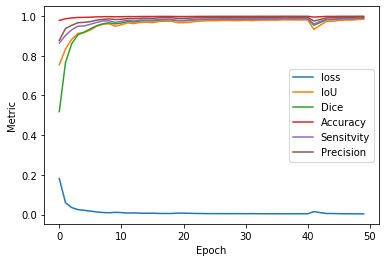

----------
Epoch 51/51
 100.0 %	loss   0.0031	IoU   0.9834	Dice   0.9888	accuracy   0.9986	sensitivity   0.9895	precision   0.9946	52m 8s


In [9]:
NUM_EPOCHS = 51
BATCH_SIZE = 4  # 每次迭代时的数据量，即input=(80, 128, 128)

model = AttU_Net().to(device)  # 选择设备：'gpu' or 'cpu'
model.train()  # 一定要表明是训练模式!!!
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_fn = nn.BCEWithLogitsLoss()

train_dataloader = DataLoader(
    liver_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = liver_dataset.__len__() // BATCH_SIZE
print(steps, "steps per epoch")

# test
# for step, (x, y) in enumerate(train_dataloader):
#     print("step:", step, ", len_x = ", len(x), "len_y = ", len(y))

start = time.time()
train_losses = []
train_ious = []
train_dices = []
train_accuracy = []
train_sensitivity = []
train_precision = []

for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []
    running_dice = []
    running_accuracy = []
    running_sensitivity = []
    running_precision = []
    
    # 根据batch size提取样本丢进模型里
    for step, (x, y) in enumerate(train_dataloader):
        loss, iou, dice, accuracy, sensitivity, precision = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)
        running_dice.append(dice)
        running_accuracy.append(accuracy)
        running_sensitivity.append(sensitivity)
        running_precision.append(precision)
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\tDice {:8.4f}\taccuracy {:8.4f}\tsensitivity {:8.4f}\tprecision {:8.4f}'.format(
            100*(step+1)/steps, loss, iou, dice, accuracy, sensitivity, precision), end="")

    print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\tDice {:8.4f}\taccuracy {:8.4f}\tsensitivity {:8.4f}\tprecision {:8.4f}\t{}'.format(
        100*(step+1)/steps, np.mean(running_loss), np.mean(running_iou),np.mean(running_dice), np.mean(running_accuracy), np.mean(running_sensitivity),np.mean(running_precision), timeSince(start)))
    scheduler.step(np.mean(running_iou))

    train_losses.append(np.mean(running_loss))
    train_ious.append(np.mean(running_iou))
    train_dices.append(np.mean(running_dice))
    train_accuracy.append(np.mean(running_accuracy))
    train_sensitivity.append(np.mean(running_sensitivity))
    train_precision.append(np.mean(running_precision))
    if epoch % 50 is 0:
        save_model_args(epoch)